

# WITH HEATMAP

# main code

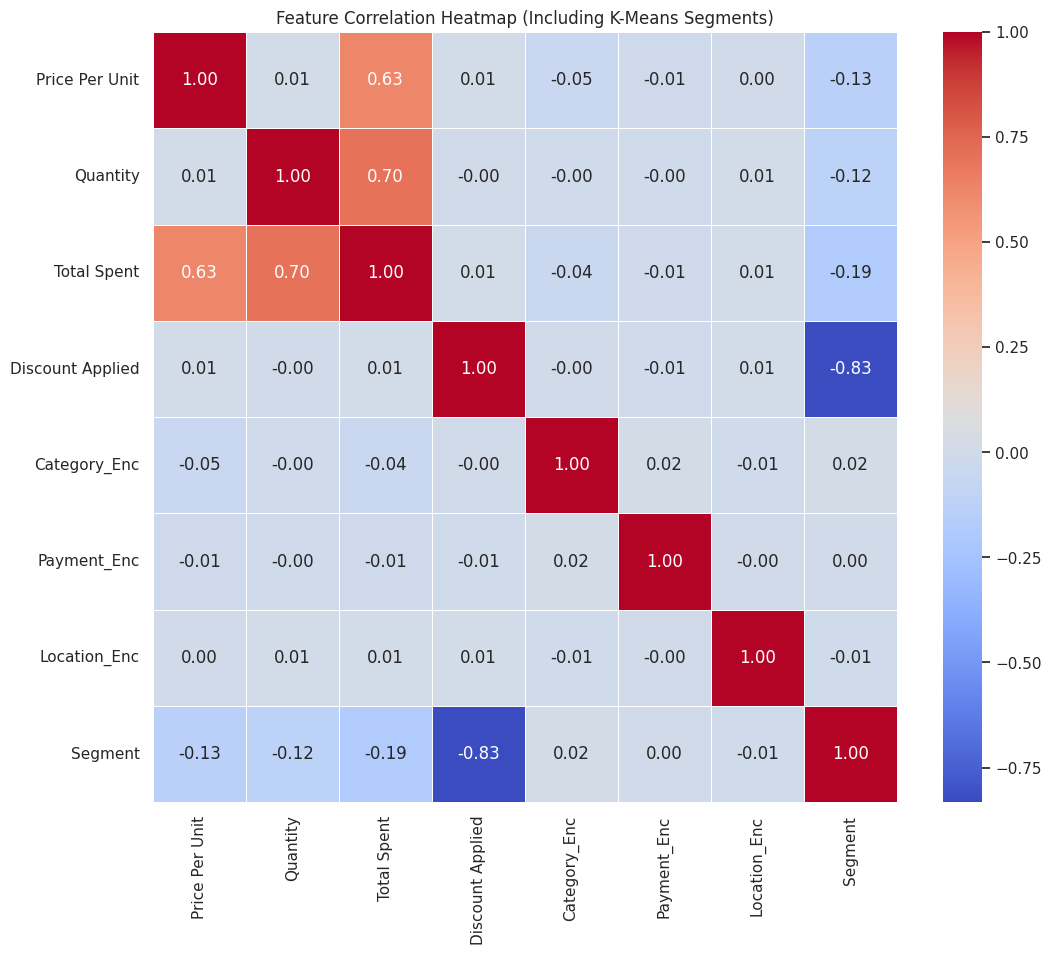

--- Detailed Model Comparison Report (Segment Prediction) ---

>> MODEL: Gaussian Naive Bayes
Accuracy:  0.7038
ROC AUC:   0.9977


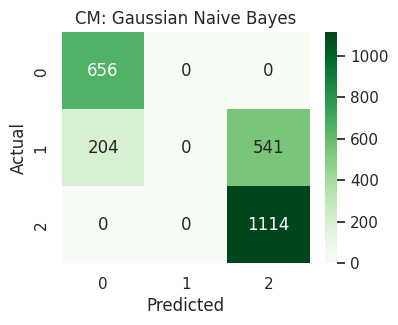


>> MODEL: Logistic Regression
Accuracy:  0.9746
ROC AUC:   0.9980


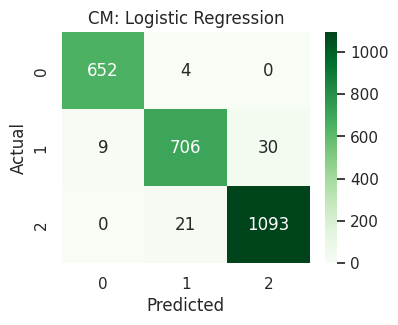


>> MODEL: Neural Network
Accuracy:  0.9901
ROC AUC:   0.9997


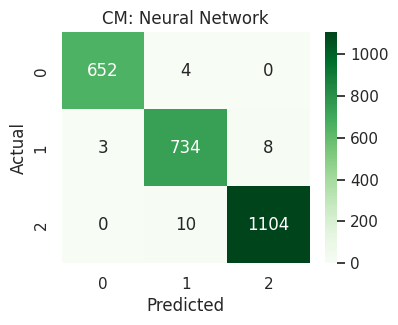


>> MODEL: Random Forest
Accuracy:  0.9897
ROC AUC:   0.9981


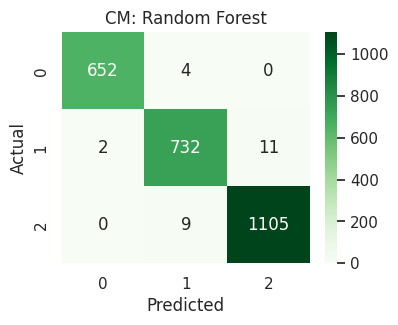

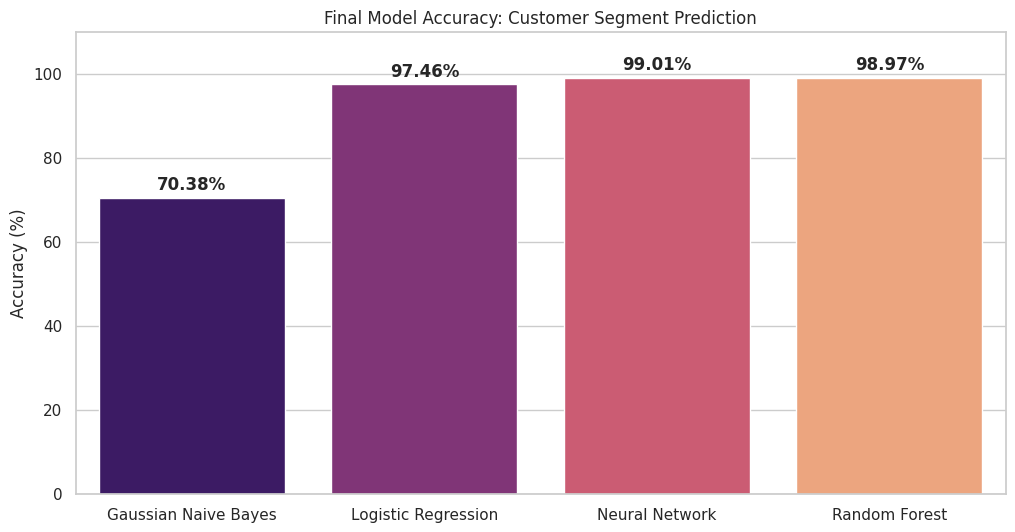

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, auc)

def run_analysis():
    # 1. Load Data
    try:
        df = pd.read_csv('retail_store_sales.csv')
    except FileNotFoundError:
        print("Error: retail_store_sales.csv not found.")
        return

    # 2. Data Cleaning & Imputation
    df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Price Per Unit'].median())
    df['Quantity'] = df['Quantity'].fillna(df['Quantity'].median())
    df['Total Spent'] = df['Total Spent'].fillna(df['Price Per Unit'] * df['Quantity'])
    df['Discount Applied'] = df['Discount Applied'].fillna('False').map({'True': 1, 'False': 0, True: 1, False: 0})

    # 3. Categorical Encoding
    le = LabelEncoder()
    df['Category_Enc'] = le.fit_transform(df['Category'].astype(str))
    df['Payment_Enc'] = le.fit_transform(df['Payment Method'].astype(str))
    df['Location_Enc'] = le.fit_transform(df['Location'].astype(str))

    # 4. Unsupervised Component: K-Means Clustering (Target Definition)
    cluster_cols = ['Price Per Unit', 'Quantity', 'Total Spent', 'Discount Applied']
    scaler_cluster = StandardScaler()
    scaled_clustering = scaler_cluster.fit_transform(df[cluster_cols])

    # Creating 3 distinct customer segments
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['Segment'] = kmeans.fit_predict(scaled_clustering)

    # --- Correlation Heatmap ---
    plt.figure(figsize=(12, 10))
    corr_cols = ['Price Per Unit', 'Quantity', 'Total Spent', 'Discount Applied',
                 'Category_Enc', 'Payment_Enc', 'Location_Enc', 'Segment']
    correlation_matrix = df[corr_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Feature Correlation Heatmap (Including K-Means Segments)')
    plt.show()

    # 5. Feature Selection and Splitting
    features = ['Category_Enc', 'Price Per Unit', 'Quantity', 'Payment_Enc', 'Location_Enc', 'Discount Applied']
    X = df[features]
    y = df['Segment']

    # 80/20 Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 6. Model Training & Evaluation (Including Random Forest)
    models = {
        "Gaussian Naive Bayes": GaussianNB(),
        "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    accuracy_results = {}
    print("--- Detailed Model Comparison Report (Segment Prediction) ---")

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        accuracy_results[name] = acc * 100

        # Multiclass ROC AUC
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
        avg_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

        print(f"\n>> MODEL: {name}")
        print(f"Accuracy:  {acc:.4f}")
        print(f"ROC AUC:   {avg_auc:.4f}")

        # Confusion Matrix
        plt.figure(figsize=(4, 3))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
        plt.title(f'CM: {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Final Accuracy Visualization
    plt.figure(figsize=(12, 6))
    model_names = list(accuracy_results.keys())
    acc_values = list(accuracy_results.values())
    sns.barplot(x=model_names, y=acc_values, hue=model_names, palette='magma', legend=False)
    plt.ylim(0, 110)
    plt.ylabel('Accuracy (%)')
    plt.title('Final Model Accuracy: Customer Segment Prediction')
    for i, v in enumerate(acc_values):
        plt.text(i, v + 2, f'{v:.2f}%', ha='center', fontweight='bold')
    plt.show()

if __name__ == "__main__":
    run_analysis()

# EDA and Visualizations


--- Statistical Summary ---
       Price Per Unit      Quantity   Total Spent
count    12575.000000  12575.000000  12575.000000
mean        23.348191      5.558648    130.208111
std         10.480413      2.790160     93.580667
min          5.000000      1.000000      5.000000
25%         14.000000      3.000000     52.000000
50%         23.000000      6.000000    110.000000
75%         32.000000      8.000000    192.000000
max         41.000000     10.000000    410.000000

--- Missing Values ---
Transaction ID         0
Customer ID            0
Category               0
Item                1213
Price Per Unit         0
Quantity               0
Total Spent            0
Payment Method         0
Location               0
Transaction Date       0
Discount Applied       0
dtype: int64


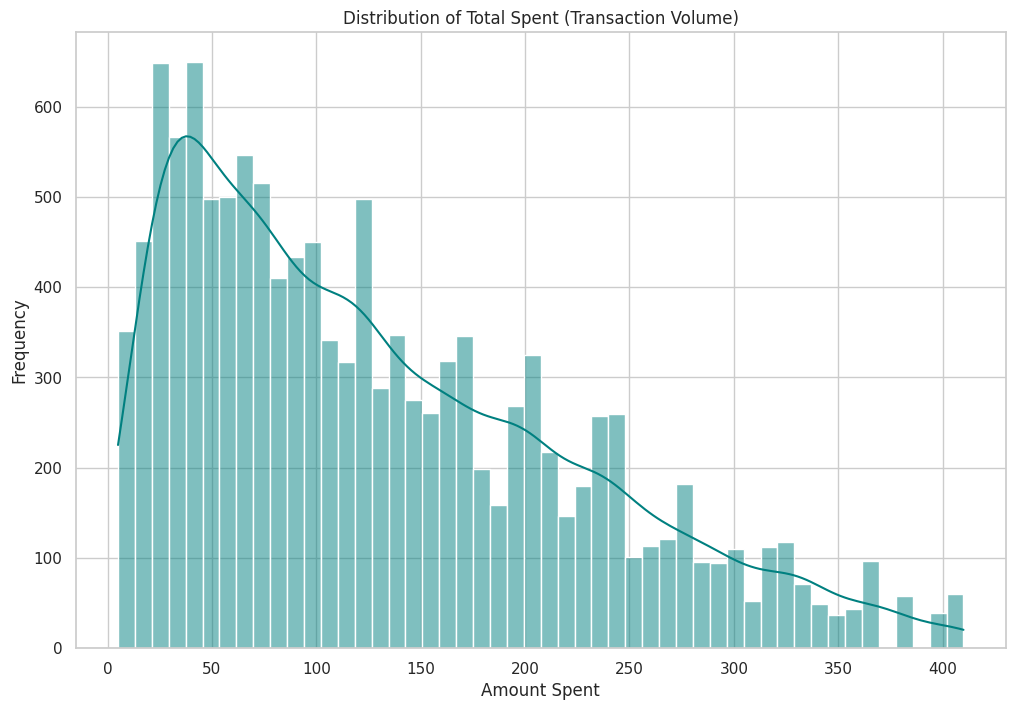

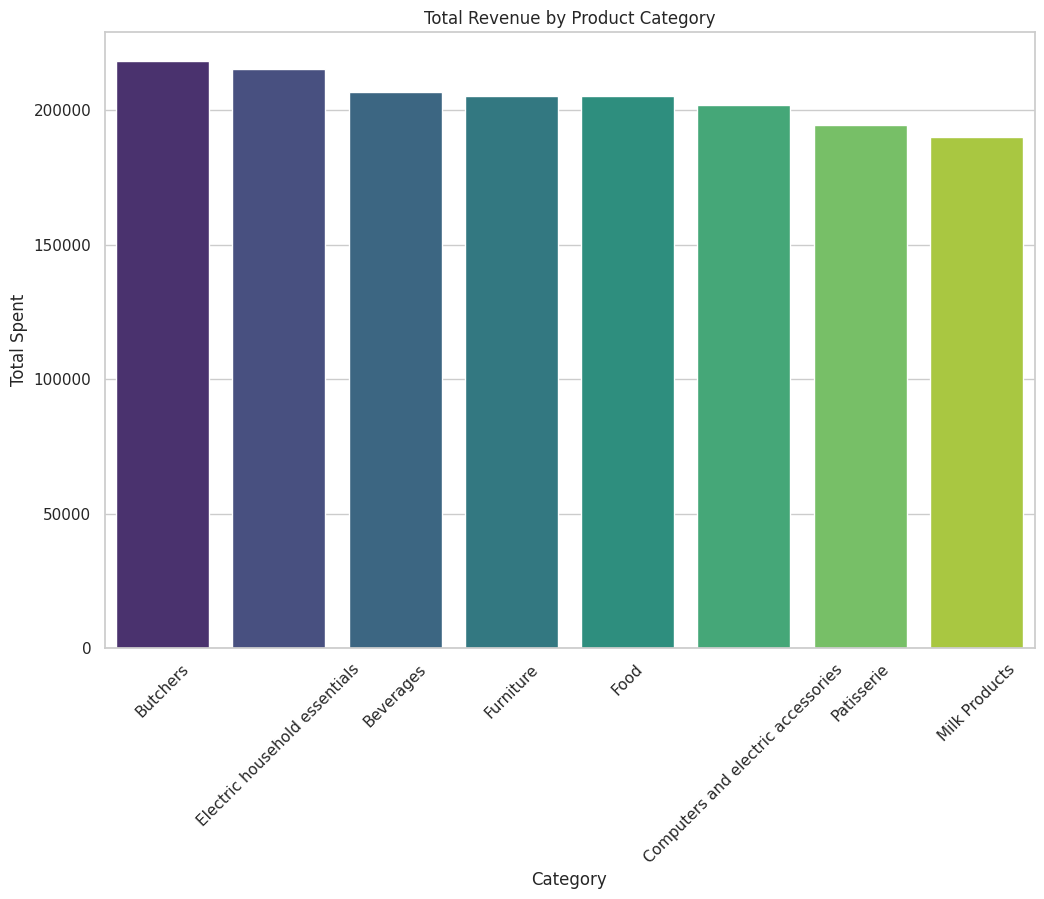

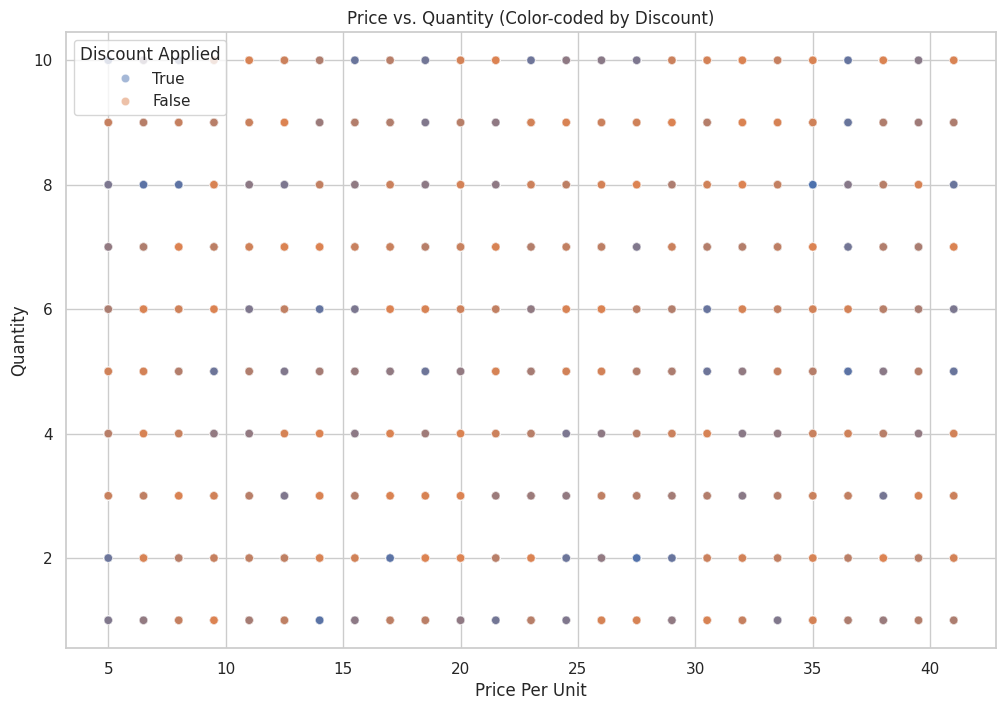

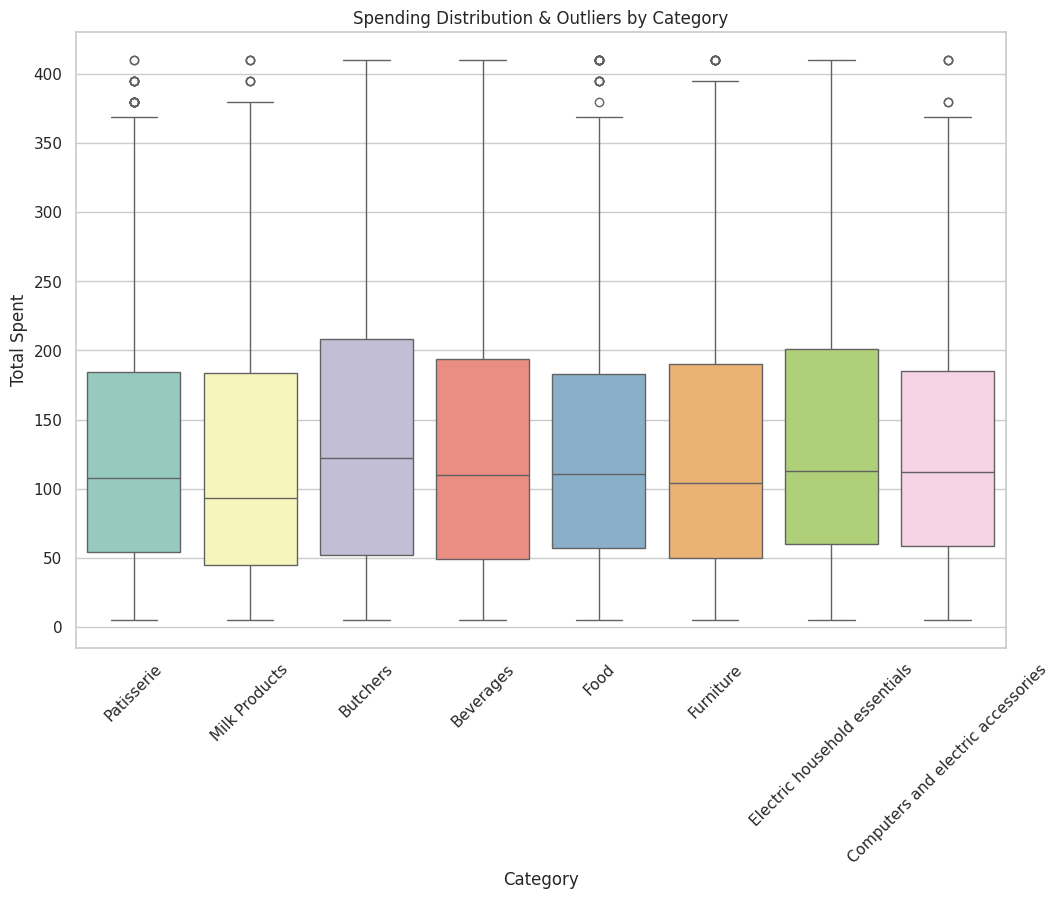

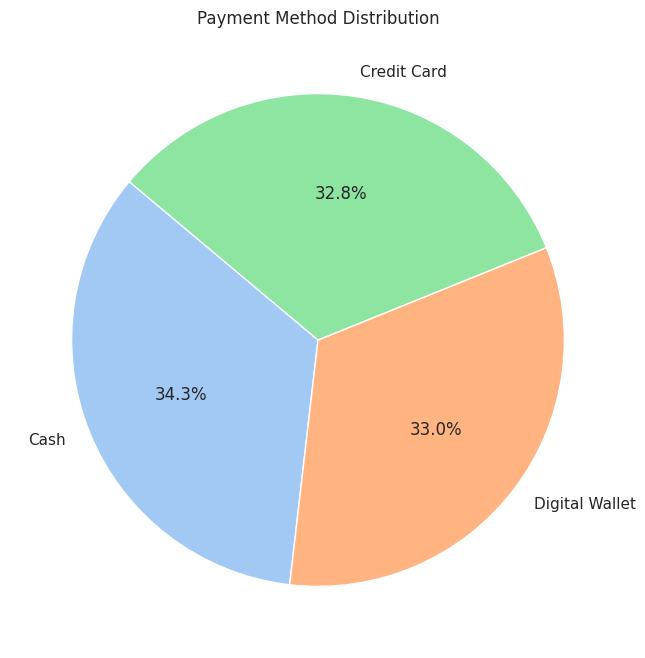

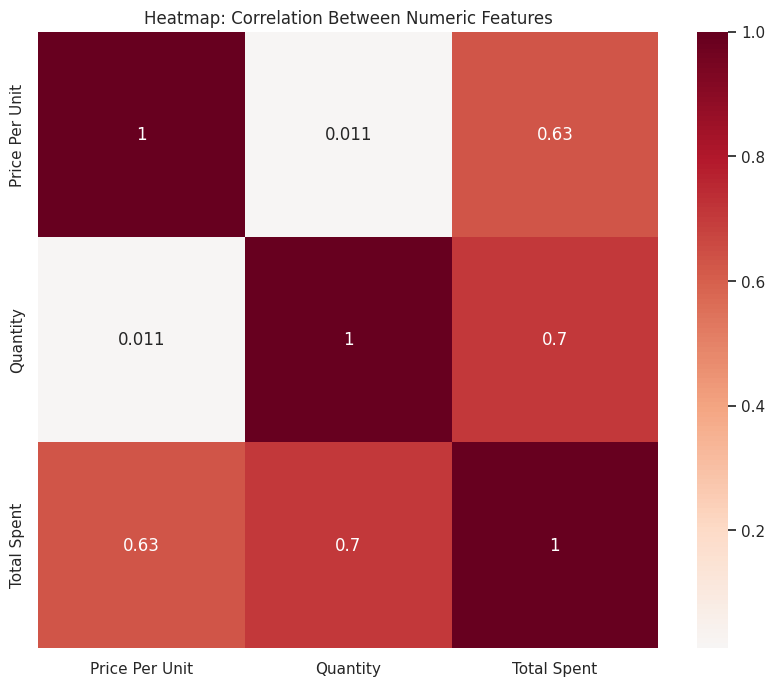

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_eda():
    # 1. Load Data
    try:
        df = pd.read_csv('retail_store_sales.csv')
    except FileNotFoundError:
        print("Error: retail_store_sales.csv not found.")
        return

    # Basic Cleaning for Visualization
    df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Price Per Unit'].median())
    df['Quantity'] = df['Quantity'].fillna(df['Quantity'].median())
    df['Total Spent'] = df['Total Spent'].fillna(df['Price Per Unit'] * df['Quantity'])
    df['Discount Applied'] = df['Discount Applied'].fillna('False').astype(str)

    # Set Visual Style
    sns.set_theme(style="whitegrid")
    plt.rcParams['figure.figsize'] = (12, 8)

    print("--- Statistical Summary ---")
    print(df.describe())
    print("\n--- Missing Values ---")
    print(df.isnull().sum())

    # 1. Distribution of Total Spent
    plt.figure()
    sns.histplot(df['Total Spent'], bins=50, kde=True, color='teal')
    plt.title('Distribution of Total Spent (Transaction Volume)')
    plt.xlabel('Amount Spent')
    plt.ylabel('Frequency')
    plt.show()

    # 2. Category-wise Total Spent (Bar Chart)
    plt.figure()
    cat_spent = df.groupby('Category')['Total Spent'].sum().sort_values(ascending=False).reset_index()
    sns.barplot(data=cat_spent, x='Category', y='Total Spent', palette='viridis', hue='Category', legend=False)
    plt.title('Total Revenue by Product Category')
    plt.xticks(rotation=45)
    plt.show()

    # 3. Quantity vs. Price Per Unit (Scatter Plot)
    plt.figure()
    sns.scatterplot(data=df, x='Price Per Unit', y='Quantity', hue='Discount Applied', alpha=0.5)
    plt.title('Price vs. Quantity (Color-coded by Discount)')
    plt.show()

    # 4. Boxplot: Total Spent by Category (Outlier Detection)
    plt.figure()
    sns.boxplot(data=df, x='Category', y='Total Spent', palette='Set3', hue='Category', legend=False)
    plt.title('Spending Distribution & Outliers by Category')
    plt.xticks(rotation=45)
    plt.show()

    # 5. Payment Method Usage (Pie Chart)
    plt.figure()
    payment_counts = df['Payment Method'].value_counts()
    plt.pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Payment Method Distribution')
    plt.show()

    # 6. Correlation Heatmap (Numeric Only)
    plt.figure(figsize=(10, 8))
    numeric_df = df.select_dtypes(include=[np.number])
    sns.heatmap(numeric_df.corr(), annot=True, cmap='RdBu_r', center=0)
    plt.title('Heatmap: Correlation Between Numeric Features')
    plt.show()

if __name__ == "__main__":
    run_eda()

## ROC F1 AND ETC

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1000x800 with 0 Axes>

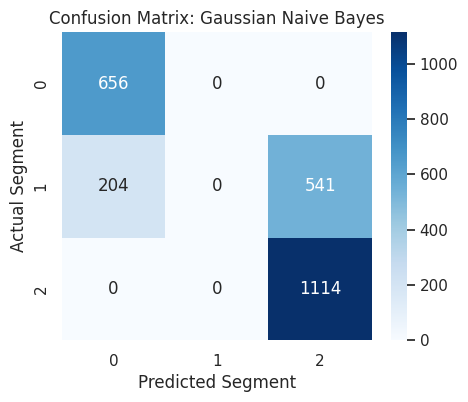

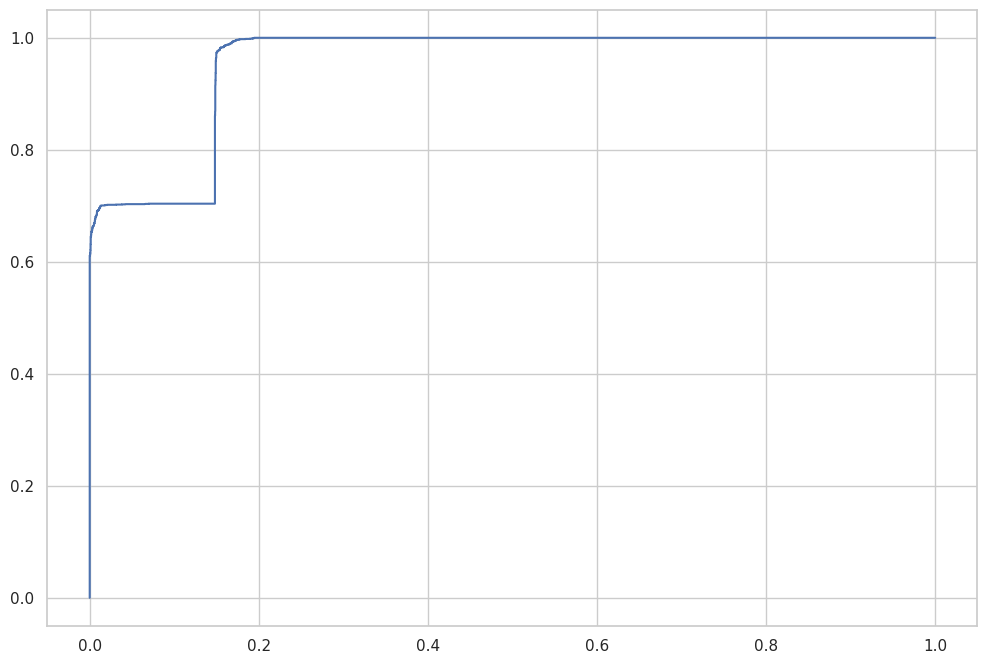

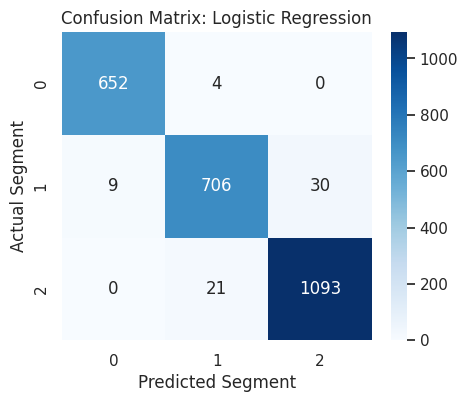

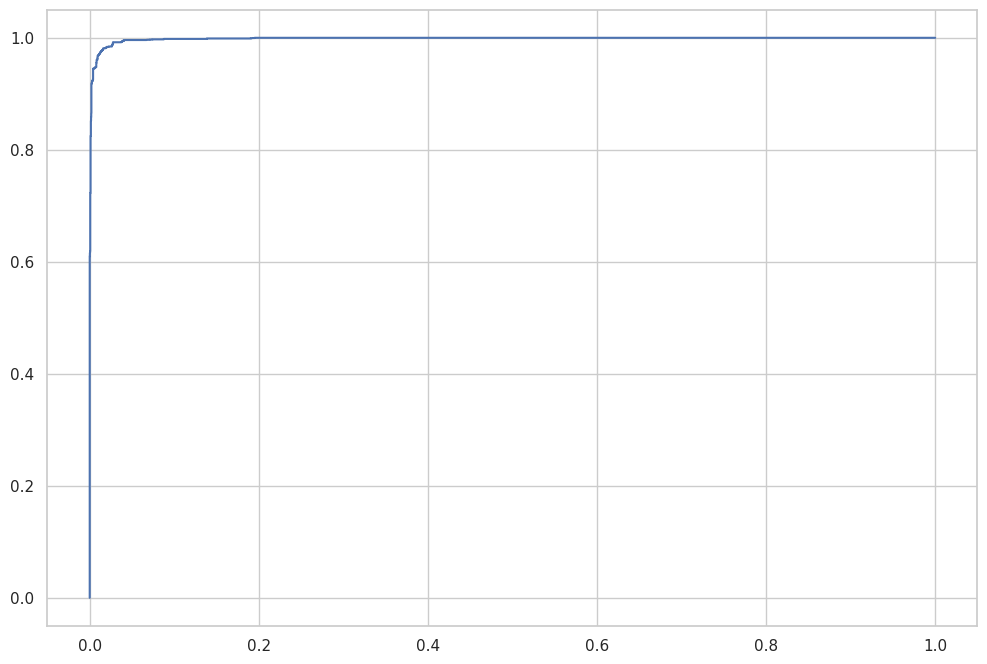

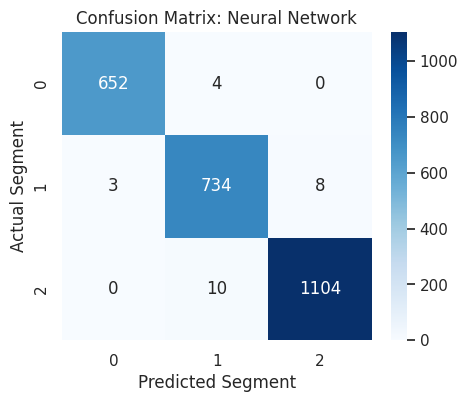

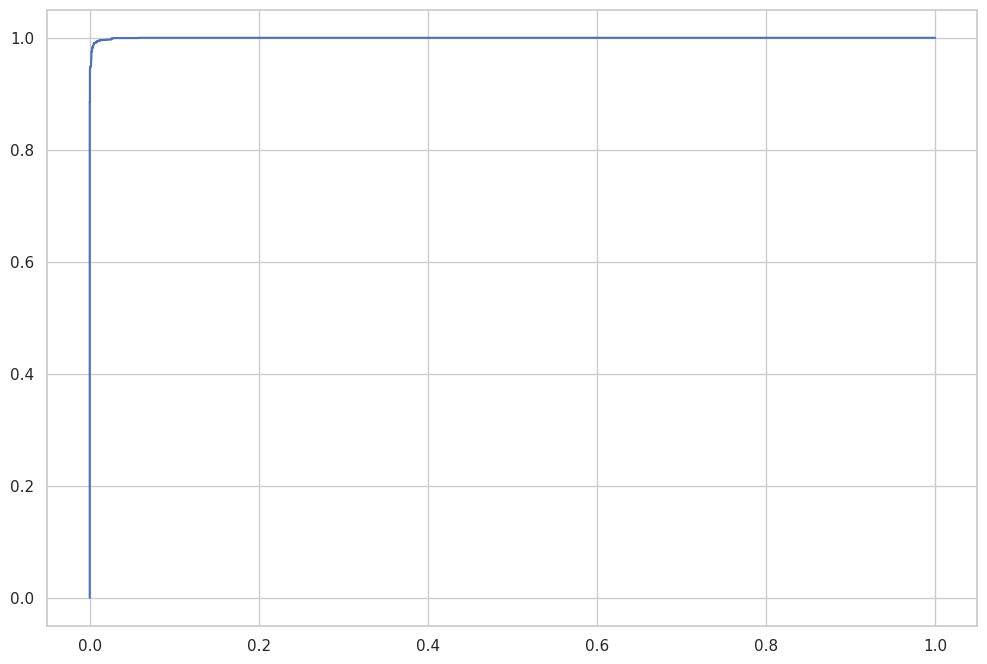

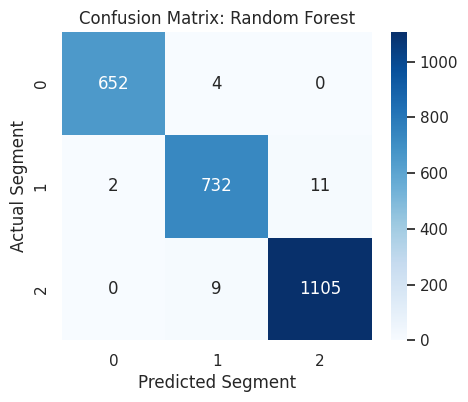

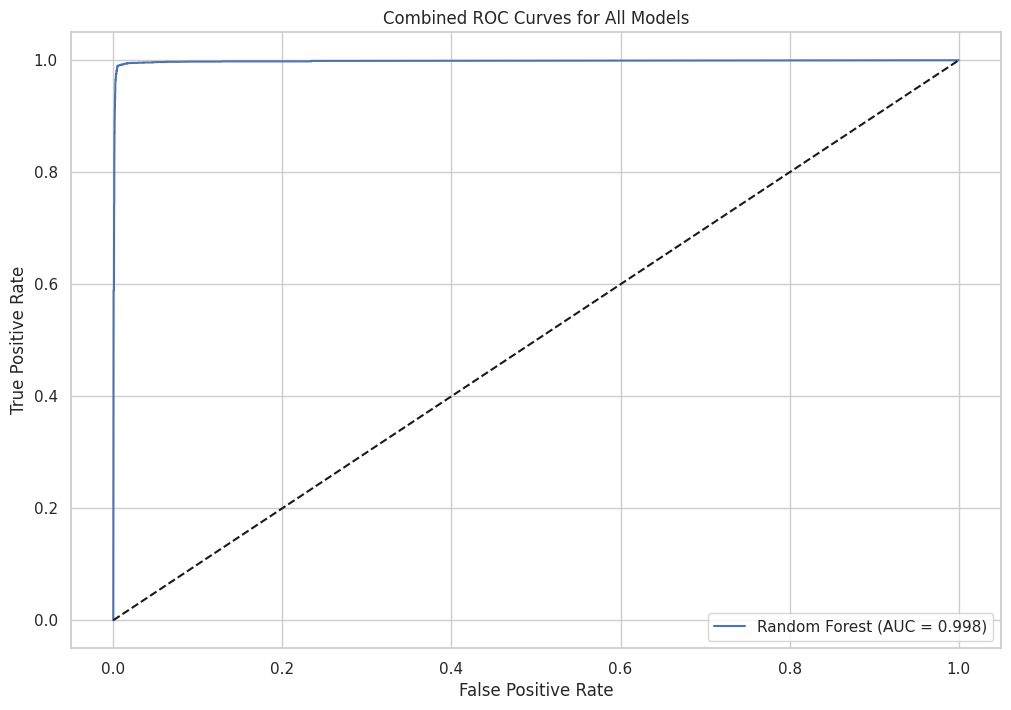


--- Detailed Model Comparison Report ---
               Model  Accuracy  Precision   Recall  F1-Score      AUC
Gaussian Naive Bayes  0.703777   0.497112 0.703777  0.582137 0.997654
 Logistic Regression  0.974553   0.974485 0.974553  0.974483 0.997995
      Neural Network  0.990060   0.990074 0.990060  0.990065 0.999668
       Random Forest  0.989662   0.989667 0.989662  0.989664 0.998080


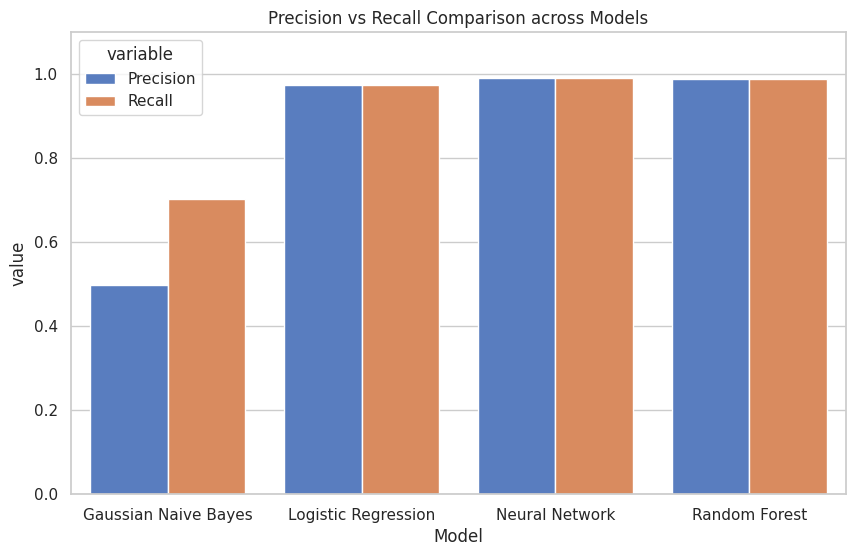

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_auc_score, roc_curve, auc)

def run_analysis():
    # 1. Load Data
    try:
        df = pd.read_csv('retail_store_sales.csv')
    except FileNotFoundError:
        print("Error: retail_store_sales.csv not found.")
        return

    # 2. Data Cleaning & Imputation
    df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Price Per Unit'].median())
    df['Quantity'] = df['Quantity'].fillna(df['Quantity'].median())
    df['Total Spent'] = df['Total Spent'].fillna(df['Price Per Unit'] * df['Quantity'])
    df['Discount Applied'] = df['Discount Applied'].fillna('False').map({'True': 1, 'False': 0, True: 1, False: 0})

    # 3. Categorical Encoding
    le = LabelEncoder()
    df['Category_Enc'] = le.fit_transform(df['Category'].astype(str))
    df['Payment_Enc'] = le.fit_transform(df['Payment Method'].astype(str))
    df['Location_Enc'] = le.fit_transform(df['Location'].astype(str))

    # 4. Unsupervised Component: K-Means Clustering
    cluster_cols = ['Price Per Unit', 'Quantity', 'Total Spent', 'Discount Applied']
    scaler_cluster = StandardScaler()
    scaled_clustering = scaler_cluster.fit_transform(df[cluster_cols])
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['Segment'] = kmeans.fit_predict(scaled_clustering)

    # 5. Feature Selection and Splitting
    features = ['Category_Enc', 'Price Per Unit', 'Quantity', 'Payment_Enc', 'Location_Enc', 'Discount Applied']
    X = df[features]
    y = df['Segment']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 6. Model Training & Detailed Evaluation
    models = {
        "Gaussian Naive Bayes": GaussianNB(),
        "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
        "Neural Network": MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=1000, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    results = []
    plt.figure(figsize=(10, 8)) # Unified ROC Plot

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)

        # Metrics Calculation
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Multiclass ROC AUC
        y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
        avg_auc = roc_auc_score(y_test_bin, y_prob, multi_class='ovr')

        results.append({
            "Model": name, "Accuracy": acc, "Precision": prec,
            "Recall": rec, "F1-Score": f1, "AUC": avg_auc
        })

        # --- Confusion Matrix Visualization ---
        plt.figure(figsize=(5, 4))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix: {name}')
        plt.xlabel('Predicted Segment')
        plt.ylabel('Actual Segment')
        plt.show()

        # --- ROC Curve Data for Plotting ---
        fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
        plt.figure(1) # Back to unified plot
        plt.plot(fpr, tpr, label=f'{name} (AUC = {avg_auc:.3f})')

    # Finalize Unified ROC Plot
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Combined ROC Curves for All Models')
    plt.legend(loc="lower right")
    plt.show()

    # Comparison Table
    res_df = pd.DataFrame(results)
    print("\n--- Detailed Model Comparison Report ---")
    print(res_df.to_string(index=False))

    # Precision/Recall Comparison Bar Chart
    res_melted = res_df.melt(id_vars="Model", value_vars=["Precision", "Recall"])
    plt.figure(figsize=(10, 6))
    sns.barplot(data=res_melted, x="Model", y="value", hue="variable", palette="muted")
    plt.title("Precision vs Recall Comparison across Models")
    plt.ylim(0, 1.1)
    plt.show()

if __name__ == "__main__":
    run_analysis()

--- Class Distribution Analysis ---
Segment 0: 3278 instances (26.07%)
Segment 1: 3727 instances (29.64%)
Segment 2: 5570 instances (44.29%)


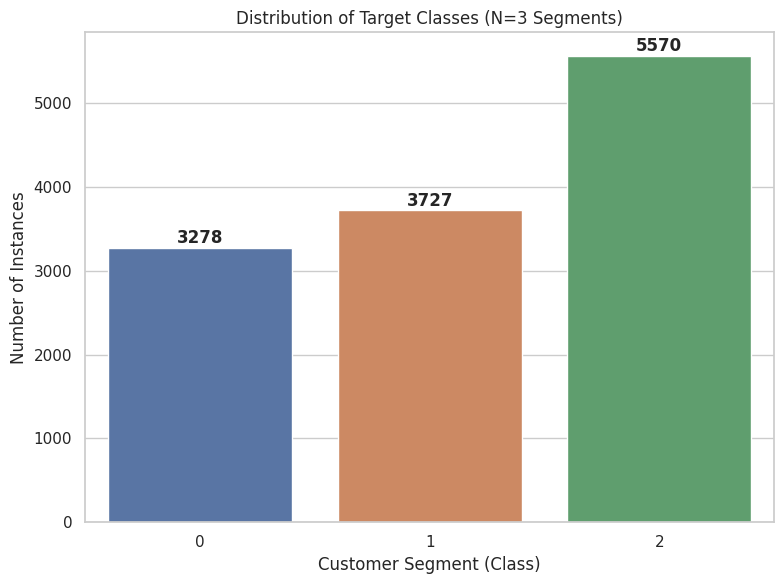

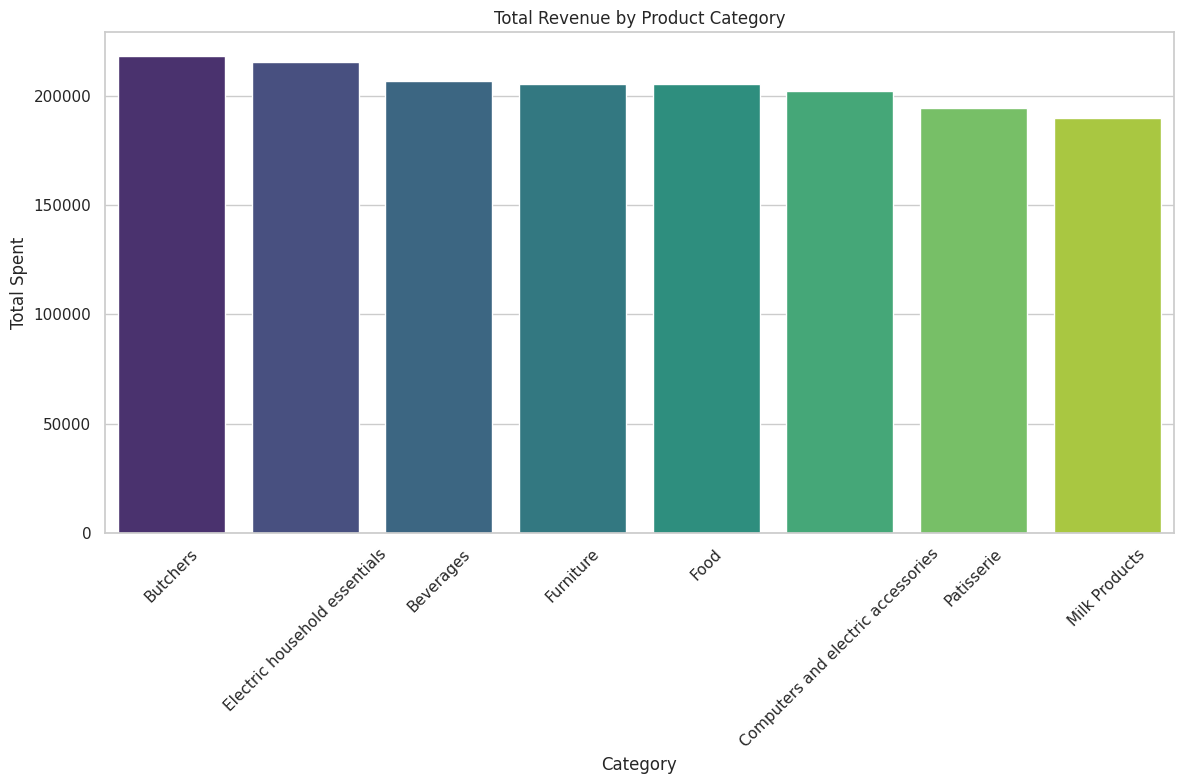

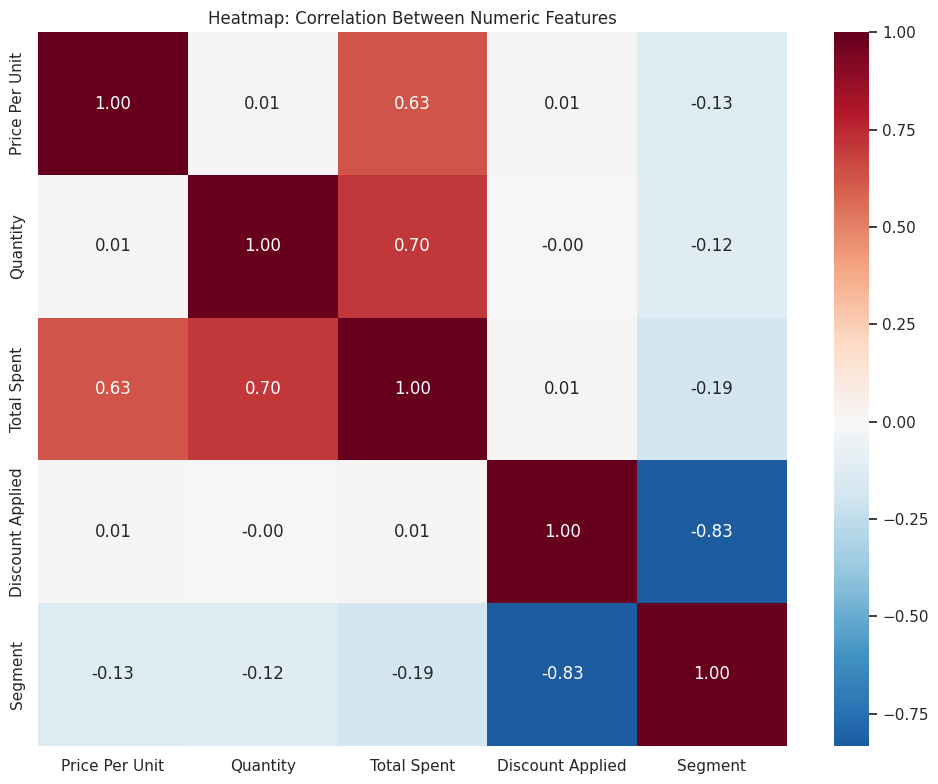

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def run_eda():
    # 1. Load Data
    try:
        df = pd.read_csv('retail_store_sales.csv')
    except FileNotFoundError:
        print("Error: retail_store_sales.csv not found.")
        return

    # Basic Cleaning
    df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Price Per Unit'].median())
    df['Quantity'] = df['Quantity'].fillna(df['Quantity'].median())
    df['Total Spent'] = df['Total Spent'].fillna(df['Price Per Unit'] * df['Quantity'])
    df['Discount Applied'] = df['Discount Applied'].fillna('False').map({'True': 1, 'False': 0, True: 1, False: 0})

    # --- Target Generation (N=3 Classes) ---
    cluster_cols = ['Price Per Unit', 'Quantity', 'Total Spent', 'Discount Applied']
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[cluster_cols])
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    df['Segment'] = kmeans.fit_predict(scaled_data)

    # --- NEW: Class Balance Analysis (Bar Chart of N classes) ---
    plt.figure(figsize=(8, 6))
    class_counts = df['Segment'].value_counts().sort_index()

    # Calculate balance percentages
    total = len(df)
    print("--- Class Distribution Analysis ---")
    for i, count in class_counts.items():
        print(f"Segment {i}: {count} instances ({ (count/total)*100:.2f}%)")

    sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette='deep', legend=False)
    plt.title('Distribution of Target Classes (N=3 Segments)')
    plt.xlabel('Customer Segment (Class)')
    plt.ylabel('Number of Instances')

    # Annotate bars with counts
    for i, count in enumerate(class_counts.values):
        plt.text(i, count + 50, str(count), ha='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # --- MANDATORY EDA ---
    # Revenue by Category
    plt.figure()
    cat_spent = df.groupby('Category')['Total Spent'].sum().sort_values(ascending=False).reset_index()
    sns.barplot(data=cat_spent, x='Category', y='Total Spent', palette='viridis', hue='Category', legend=False)
    plt.title('Total Revenue by Product Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Heatmap
    plt.figure(figsize=(10, 8))
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='RdBu_r', center=0, fmt=".2f")
    plt.title('Heatmap: Correlation Between Numeric Features')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    run_eda()

kmeans


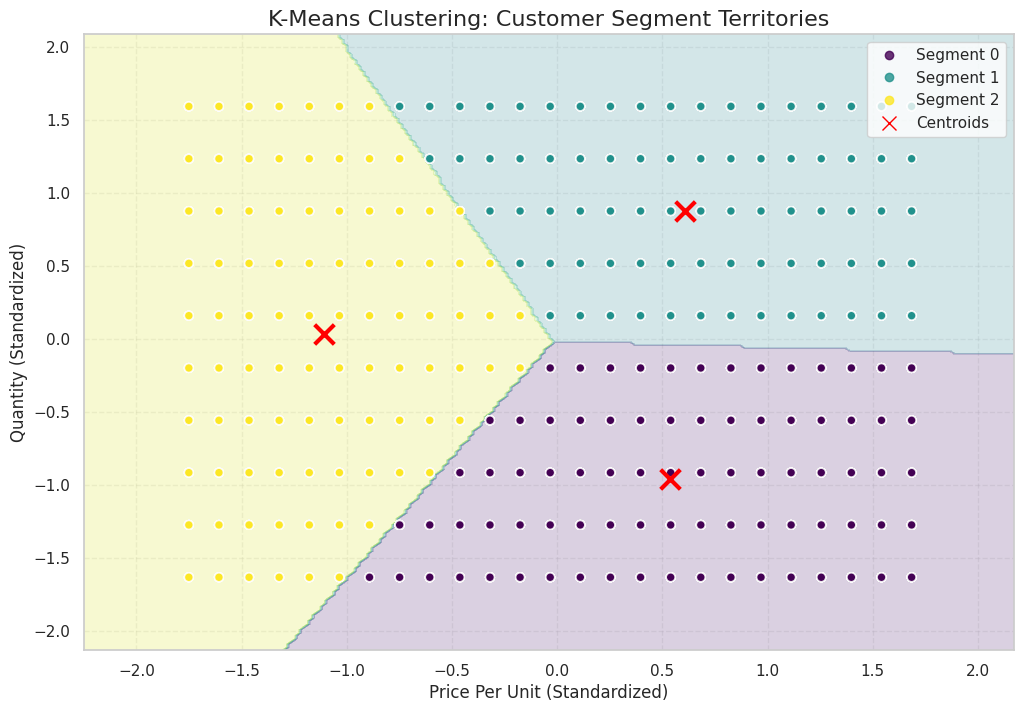

--- K-Means Cluster Characteristics (Centroids) ---
Cluster 0: Price Score: 0.53, Quantity Score: -0.96
Cluster 1: Price Score: 0.61, Quantity Score: 0.87
Cluster 2: Price Score: -1.11, Quantity Score: 0.03


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def visualize_kmeans_map():
    # 1. Load the data
    try:
        df = pd.read_csv('retail_store_sales.csv')
    except FileNotFoundError:
        print("Error: retail_store_sales.csv not found.")
        return

    # 2. Basic Cleaning
    df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Price Per Unit'].median())
    df['Quantity'] = df['Quantity'].fillna(df['Quantity'].median())
    df['Total Spent'] = df['Total Spent'].fillna(df['Price Per Unit'] * df['Quantity'])

    # 3. Scaling
    # We focus on the two main drivers for the 2D map: Price and Quantity
    features = ['Price Per Unit', 'Quantity']
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[features])

    # 4. Run K-Means Clustering
    # We use 3 clusters to represent: Standard, Premium, and Bulk buyers
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    df['Segment'] = clusters

    # 5. Create Decision Boundary Map
    # Define the boundaries of our plot based on scaled data
    x_min, x_max = X_scaled[:, 0].min() - 0.5, X_scaled[:, 0].max() + 0.5
    y_min, y_max = X_scaled[:, 1].min() - 0.5, X_scaled[:, 1].max() + 0.5

    # Generate a mesh grid
    h = .02  # Step size
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the cluster for every point in the mesh grid
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # 6. Plotting
    plt.figure(figsize=(12, 8))

    # Draw the colored backgrounds (Decision Boundaries)
    plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')

    # Scatter plot of actual data points
    # We use the scaled data so it aligns with the decision boundaries
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
                        cmap='viridis', edgecolor='white', s=40, alpha=0.8)

    # Add centroids (the "center" of each cluster)
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=200,
                linewidths=3, color='red', label='Cluster Centroids', zorder=10)

    # Formatting
    plt.title('K-Means Clustering: Customer Segment Territories', fontsize=16)
    plt.xlabel('Price Per Unit (Standardized)', fontsize=12)
    plt.ylabel('Quantity (Standardized)', fontsize=12)

    # Legend
    # Since scaling loses the original labels, we map them by their general location
    # Typically: High X = Premium, High Y = Bulk, Center/Low = Standard
    legend_labels = ['Segment 0', 'Segment 1', 'Segment 2']
    handles, _ = scatter.legend_elements()
    plt.legend(handles + [plt.Line2D([0], [0], marker='x', color='red', linestyle='', markersize=10)],
               legend_labels + ['Centroids'], loc="upper right")

    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    # Print summary of the clusters
    print("--- K-Means Cluster Characteristics (Centroids) ---")
    for i, center in enumerate(centroids):
        print(f"Cluster {i}: Price Score: {center[0]:.2f}, Quantity Score: {center[1]:.2f}")

if __name__ == "__main__":
    visualize_kmeans_map()